In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

print(tf.__version__)

2.10.0


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
data_news_headlines = pd.read_json("../shared_data/x1.json")

# Adjust news headline data
data_news_headlines = data_news_headlines.drop(columns='article_link', axis=1)
data_news_headlines = data_news_headlines.rename(columns ={'headline':'text', 'is_sarcastic':'label'})
data_news_headlines = data_news_headlines.reindex(columns=['text','label'])
data_news_headlines.head()

,text,label
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


In [5]:
data_tweets = pd.read_csv("../shared_data/dataset_csv.csv")

# Adjust tweets data
data_tweets = data_tweets.rename(columns={'tweets':'text'})
data_tweets.head()

,text,label
0,I love working midnights tweet,1
1,I hate when I buy a bag of air and there's chi...,1
2,my grandad always sounds so ill when i speak t...,0
3,"I realize I'm annoying to everyone, so I won't...",0
4,I love when I find these dudes on vine!! #Foll...,1


In [6]:
data_sitcoms = pd.read_csv("../shared_data/mustard++_text.csv")

# Adjust sitcom data
data_sitcoms = data_sitcoms.drop(columns=['SCENE','KEY','END_TIME','SPEAKER','SHOW','Sarcasm_Type','Implicit_Emotion','Explicit_Emotion','Valence','Arousal'], axis=1)
data_sitcoms = data_sitcoms.rename(columns={'SENTENCE':'text','Sarcasm':'label'})

# remove empty label rows
for index, row in data_sitcoms.iterrows():
    if math.isnan(row['label']):
        data_sitcoms = data_sitcoms.drop(index, axis='index')

data_sitcoms.head()

,text,label
5,"And of those few months, how long have you bee...",0.0
14,"Let the dead man talk. So, why do you think that?",0.0
18,"What else? Sell it on eBay as ""slightly used.""",0.0
24,"Good idea, sit with her. Hold her, comfort her...",1.0
31,"Well, now that I've given up string theory, I'...",0.0


In [7]:
data_reddit = pd.read_csv("../shared_data/train-balanced-sarcasm.csv")

# Adjust reddit data
data_reddit = data_reddit.drop(columns=['author','subreddit','score','ups','downs','date','created_utc','parent_comment'], axis=1)
data_reddit = data_reddit.rename(columns={'comment':'text'})
data_reddit = data_reddit.reindex(columns=['text','label'])

data_reddit.head()

,text,label
0,NC and NH.,0
1,You do know west teams play against west teams...,0
2,"They were underdogs earlier today, but since G...",0
3,"This meme isn't funny none of the ""new york ni...",0
4,I could use one of those tools.,0


In [8]:
# Combine all 4 datasets
data = pd.concat([data_news_headlines,data_tweets,data_sitcoms,data_reddit], ignore_index=True)

# remove non string (nan) rows
for index, row in data.iterrows():
    if not type(row['text']) == str:
        data = data.drop(index, axis='index')

# Shuffle the rows
data = data.sample(frac=1).reset_index(drop=True)

data.head()

,text,label
0,Source?,0.0
1,Yeah but why delay the inevitable?,1.0
2,"Wow, they look so alike!",1.0
3,on eu they will probably be released 1-2 weeks...,1.0
4,All your link shows is part of Govia's astrotu...,0.0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042588 entries, 0 to 1042587
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   text    1042588 non-null  object 
 1   label   1042588 non-null  float64
dtypes: float64(1), object(1)
memory usage: 15.9+ MB


In [10]:
#find longest sentence and average sentence length
longest_sentence_length = 0
longest_sentence_text = ''
longest_sentence_label = 0
longest_sentence_index = 0
sum_word_count = 0
sum_number_of_sentences = 0
average_sentence_length = 0


for index, row in data.iterrows():
    sentence_length = len(row['text'].split())
    sum_word_count += sentence_length
    sum_number_of_sentences += 1
    #remove junk sentences
    if sentence_length > 1500:
        data = data.drop(index, axis='index')
        continue
    # proceed to set longest sentence variables
    if longest_sentence_length < sentence_length:
        longest_sentence_length = sentence_length
        longest_sentence_text = row['text']
        longest_sentence_label = row['label']
        longest_sentence_index = index
    


average_sentence_length = sum_word_count / sum_number_of_sentences


print('longest_sentence_length: {}'.format(longest_sentence_length))
print('average_sentence_length: {}'.format(average_sentence_length))
print('longest_sentence_text: {}'.format(longest_sentence_text))
print('longest_sentence_label: {}'.format(longest_sentence_label))

longest_sentence_length: 1425
average_sentence_length: 10.464075934117792
longest_sentence_text: PATCH NOTES General Gameplay Fixed technology becoming instantly fully charged when repaired Fixed ship appearing on incorrect pad in space station after loading Added interactable objects that required certain tech to collect Added shootable objects that require certain tech to mine Rebalanced resource availability and technology charge requirements Fixed initial game flow - where travelling to space too quickly after visiting the monolith could prevent the first atlas station notification appearing Prevented player being prompted to scan for buildings before leaving the system after visiting the monolith Prevented laser and melee attacks while in space from attempting to edit terrain Improved calculation of resources received when mining terrain Renamed Signal Scanners to Signal Boosters Signal booster objects updated to search for playable bases, suit upgrade pods, and mineable resources

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1042579 entries, 0 to 1042587
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   text    1042579 non-null  object 
 1   label   1042579 non-null  float64
dtypes: float64(1), object(1)
memory usage: 23.9+ MB


In [12]:
max_features = 10000  # Maximum vocab size.
max_len = 128  # Sequence length to pad the outputs to.
num_filters = 8
filter_size = 3
pool_size = 2
training_size = 200000

In [13]:
text_dataset = tf.data.Dataset.from_tensor_slices(data['text'])
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens=max_features,
 output_mode='int',
 output_sequence_length=max_len)

vectorize_layer.adapt(text_dataset.batch(64))

In [29]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(input_dim=max_len,output_dim=32))
model.add(tf.keras.layers.Conv1D(32, 7, padding='same'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=pool_size))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(
  'adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, 128, 32)           4096      
                                                                 
 conv1d_6 (Conv1D)           (None, 128, 32)           7200      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 64, 32)           0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [15]:
text = list(data['text'])
labels = list(data['label'])
##training set from 0 to training size
training_sentences = text[0:training_size]
training_labels = labels[0:training_size]

##testing set from training size to the end
testing_sentences = text[training_size:]
testing_labels = labels[training_size:]

In [33]:
num_epochs = 30
history = model.fit(
    training_sentences, 
    training_labels, 
    epochs=num_epochs,
    validation_data=(testing_sentences, testing_labels)
    )

Epoch 1/30
6250/6250 [==============================] - 255s 41ms/step - loss: 0.5968 - accuracy: 0.6680 - val_loss: 0.6344 - val_accuracy: 0.6385
Epoch 2/30
6250/6250 [==============================] - 236s 38ms/step - loss: 0.5951 - accuracy: 0.6702 - val_loss: 0.6351 - val_accuracy: 0.6377
Epoch 3/30
6250/6250 [==============================] - 233s 37ms/step - loss: 0.5934 - accuracy: 0.6716 - val_loss: 0.6363 - val_accuracy: 0.6395
Epoch 4/30
6250/6250 [==============================] - 233s 37ms/step - loss: 0.5922 - accuracy: 0.6730 - val_loss: 0.6334 - val_accuracy: 0.6415
Epoch 5/30
6250/6250 [==============================] - 234s 37ms/step - loss: 0.5909 - accuracy: 0.6744 - val_loss: 0.6379 - val_accuracy: 0.6399
Epoch 6/30
6250/6250 [==============================] - 231s 37ms/step - loss: 0.5900 - accuracy: 0.6757 - val_loss: 0.6367 - val_accuracy: 0.6390
Epoch 7/30
6250/6250 [==============================] - 232s 37ms/step - loss: 0.5889 - accuracy: 0.6759 - val_loss: 0

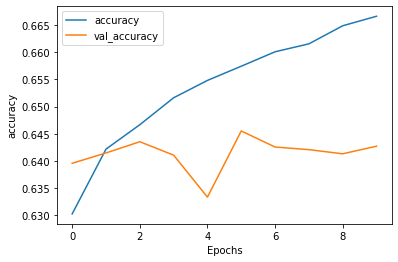

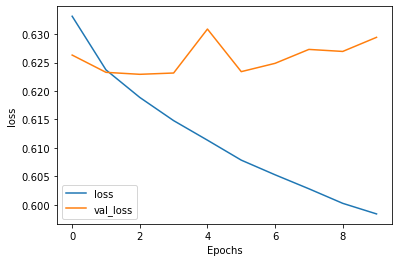

In [ ]:
def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
  
plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

In [ ]:
new_sentences = ["Now we know why some animals eat their own children.", "game of thrones season finale showing this sunday night","Please, keep talking. I always yawn when I am interested."]
print(round(model.predict(new_sentences)))

1/1 [==============================] - 5s 5s/step
[[0.48983118 0.51016885]
 [0.48879144 0.5112086 ]
 [0.49169677 0.5083032 ]]


In [ ]:
model.save('./model_saves/cnn/')